In [1]:
# Essential imports for data science and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, precision_score, recall_score)
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Configure visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Environment Setup:")
print(f"   Device: {device}")
print(f"   PyTorch Version: {torch.__version__}")
print(f"   Pandas Version: {pd.__version__}")
print(f"   NumPy Version: {np.__version__}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("\n✅ All libraries imported successfully!")
print("📊 Ready to begin customer churn analysis...")

🚀 Environment Setup:
   Device: cpu
   PyTorch Version: 2.8.0+cpu
   Pandas Version: 2.3.3
   NumPy Version: 2.3.3

✅ All libraries imported successfully!
📊 Ready to begin customer churn analysis...


In [2]:
# Confidence Scoring and Probability Calibration Implementation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

class ChurnConfidenceScorer:
    """
    Advanced confidence scoring system for churn predictions

    This class handles:
    1. Probability calibration
    2. Confidence scoring
    3. Risk category assignment
    4. ROI-optimized decision thresholds
    """

    def __init__(self, calibration_method='isotonic'):
        """
        Initialize confidence scorer

        Args:
            calibration_method (str): Method for probability calibration
                'isotonic': Non-parametric isotonic regression
                'platt': Platt scaling (logistic regression)
        """
        self.calibration_method = calibration_method
        self.calibrator = None
        self.thresholds = None
        self.optimal_threshold = None
        self.calibrated = False

    def fit_calibrator(self, y_true, y_pred_prob):
        """
        Fit probability calibrator using validation data

        Args:
            y_true (array-like): True binary labels
            y_pred_prob (array-like): Uncalibrated predicted probabilities
        """
        print(f"🔧 Fitting {self.calibration_method} calibration model...")

        if self.calibration_method == 'isotonic':
            self.calibrator = IsotonicRegression(out_of_bounds='clip')
            self.calibrator.fit(y_pred_prob, y_true)
        elif self.calibration_method == 'platt':
            from sklearn.linear_model import LogisticRegression
            # Reshape for scikit-learn API
            self.calibrator = LogisticRegression(C=1.0)
            self.calibrator.fit(y_pred_prob.reshape(-1, 1), y_true)
        else:
            raise ValueError(f"Unknown calibration method: {self.calibration_method}")

        self.calibrated = True
        print(f"   ✅ Calibration model fitted successfully")

    def calibrate_probabilities(self, y_pred_prob):
        """
        Apply calibration to raw prediction probabilities

        Args:
            y_pred_prob (array-like): Uncalibrated predicted probabilities

        Returns:
            array-like: Calibrated probabilities
        """
        if not self.calibrated:
            print("⚠️ Calibrator not fitted. Returning original probabilities.")
            return y_pred_prob

        if self.calibration_method == 'isotonic':
            return self.calibrator.transform(y_pred_prob)
        elif self.calibration_method == 'platt':
            # Reshape for scikit-learn API
            return self.calibrator.predict_proba(y_pred_prob.reshape(-1, 1))[:, 1]

    def evaluate_calibration(self, y_true, y_pred_prob, n_bins=10):
        """
        Evaluate and visualize probability calibration

        Args:
            y_true (array-like): True binary labels
            y_pred_prob (array-like): Predicted probabilities
            n_bins (int): Number of bins for calibration curve

        Returns:
            dict: Calibration evaluation metrics
        """
        # Calculate calibration curve
        prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=n_bins)

        # Calculate calibration error (root mean squared calibration error)
        rmsce = np.sqrt(np.mean((prob_true - prob_pred)**2))

        # Calculate expected calibration error
        bin_edges = np.linspace(0, 1, n_bins + 1)
        bin_indices = np.digitize(y_pred_prob, bin_edges[:-1]) - 1
        bin_counts = np.bincount(bin_indices, minlength=n_bins)

        # Avoid division by zero
        valid_bins = bin_counts > 0
        bin_probs = np.zeros(n_bins)
        bin_true_probs = np.zeros(n_bins)

        for i in range(n_bins):
            if bin_counts[i] > 0:
                bin_mask = bin_indices == i
                bin_probs[i] = np.mean(y_pred_prob[bin_mask])
                bin_true_probs[i] = np.mean(y_true[bin_mask])

        ece = np.sum((bin_counts[valid_bins] / len(y_true)) *
                     np.abs(bin_probs[valid_bins] - bin_true_probs[valid_bins]))

        # Visualize calibration curve
        plt.figure(figsize=(10, 8))
        plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
        plt.plot(prob_pred, prob_true, marker='o', label=f'Model calibration')

        plt.xlabel('Mean predicted probability')
        plt.ylabel('Fraction of positives (Empirical probability)')
        plt.title('Calibration Curve (Reliability Diagram)')
        plt.legend()
        plt.grid(True)

        # Add calibration error metrics to the plot
        plt.text(0.05, 0.95, f'Root Mean Squared Calibration Error: {rmsce:.4f}',
                 transform=plt.gca().transAxes, fontsize=12)
        plt.text(0.05, 0.9, f'Expected Calibration Error: {ece:.4f}',
                 transform=plt.gca().transAxes, fontsize=12)

        plt.show()

        return {
            'rmsce': rmsce,
            'ece': ece
        }

    def optimize_threshold(self, y_true, y_pred_prob, cost_matrix=None):
        """
        Find optimal decision threshold based on business costs

        Args:
            y_true (array-like): True binary labels
            y_pred_prob (array-like): Predicted probabilities
            cost_matrix (dict): Business costs dictionary with keys:
                - false_positive_cost: Cost of unnecessary intervention
                - false_negative_cost: Cost of missed churn
                - true_positive_benefit: Benefit of successful retention

        Returns:
            float: Optimal threshold that minimizes expected cost
        """
        if cost_matrix is None:
            # Default telecommunications industry costs
            cost_matrix = {
                'false_positive_cost': 50,  # Cost of unnecessary retention campaign
                'false_negative_cost': 200,  # Lost monthly revenue * average customer lifetime
                'true_positive_benefit': 400  # Retained revenue - campaign cost
            }

        thresholds = np.linspace(0.01, 0.99, 99)
        expected_costs = []

        for threshold in thresholds:
            y_pred = (y_pred_prob >= threshold).astype(int)

            # Calculate confusion matrix counts
            tp = np.sum((y_pred == 1) & (y_true == 1))
            fp = np.sum((y_pred == 1) & (y_true == 0))
            fn = np.sum((y_pred == 0) & (y_true == 1))

            # Calculate expected cost
            expected_cost = (fp * cost_matrix['false_positive_cost'] +
                            fn * cost_matrix['false_negative_cost'] -
                            tp * cost_matrix['true_positive_benefit'])

            expected_costs.append(expected_cost)

        # Find threshold with minimum cost
        optimal_idx = np.argmin(expected_costs)
        self.optimal_threshold = thresholds[optimal_idx]
        self.thresholds = {
            'values': thresholds,
            'costs': expected_costs
        }

        # Plot cost vs threshold
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, expected_costs)
        plt.axvline(self.optimal_threshold, color='r', linestyle='--',
                   label=f'Optimal threshold: {self.optimal_threshold:.2f}')
        plt.xlabel('Decision Threshold')
        plt.ylabel('Expected Cost')
        plt.title('Cost-Optimized Decision Threshold')
        plt.grid(True)
        plt.legend()
        plt.show()

        print(f"📊 Optimal decision threshold: {self.optimal_threshold:.3f}")
        print(f"   • False Positive Cost: ${cost_matrix['false_positive_cost']}")
        print(f"   • False Negative Cost: ${cost_matrix['false_negative_cost']}")
        print(f"   • True Positive Benefit: ${cost_matrix['true_positive_benefit']}")

        return self.optimal_threshold

    def get_confidence_category(self, probability):
        """
        Assign confidence category based on calibrated probability

        Args:
            probability (float): Calibrated churn probability

        Returns:
            dict: Confidence category information
        """
        if probability < 0.2:
            return {
                'risk_level': 'Very Low Risk',
                'confidence': 'Very High',
                'action': 'Standard Service',
                'priority': 'Low'
            }
        elif probability < 0.4:
            return {
                'risk_level': 'Low Risk',
                'confidence': 'High',
                'action': 'Periodic Monitoring',
                'priority': 'Low-Medium'
            }
        elif probability < 0.6:
            return {
                'risk_level': 'Uncertain',
                'confidence': 'Medium',
                'action': 'Enhanced Monitoring',
                'priority': 'Medium'
            }
        elif probability < 0.8:
            return {
                'risk_level': 'High Risk',
                'confidence': 'High',
                'action': 'Targeted Offers',
                'priority': 'High'
            }
        else:
            return {
                'risk_level': 'Very High Risk',
                'confidence': 'Very High',
                'action': 'Immediate Intervention',
                'priority': 'Critical'
            }

    def predict_with_confidence(self, probabilities):
        """
        Generate predictions with confidence information

        Args:
            probabilities (array-like): Predicted probabilities

        Returns:
            list: Prediction results with confidence categories
        """
        # Calibrate if calibrator is available
        if self.calibrated:
            calibrated_probs = self.calibrate_probabilities(probabilities)
        else:
            calibrated_probs = probabilities

        # Generate predictions using optimal threshold
        threshold = self.optimal_threshold if self.optimal_threshold else 0.5
        predictions = (calibrated_probs >= threshold).astype(int)

        # Add confidence categories
        results = []
        for prob, pred in zip(calibrated_probs, predictions):
            confidence = self.get_confidence_category(prob)
            results.append({
                'probability': float(prob),
                'prediction': int(pred),
                'risk_level': confidence['risk_level'],
                'confidence': confidence['confidence'],
                'recommended_action': confidence['action'],
                'business_priority': confidence['priority']
            })

        return results

In [17]:
import pickle

y_test = pd.read_csv("../data/preprocessed/y_test.csv")
y_test_flat = y_test.values.flatten()  # Convert (1409, 1) to (1409,)

# 1. Load metadata
with open('../outputs/model_metadata.pkl', 'rb') as f:
    metadata_object = pickle.load(f)

test_probabilities = metadata_object['test_probabilities']

y_test_flat.shape, test_probabilities.shape

((1409,), (1409,))

In [19]:
# Instantiate the confidence scorer
print("🏗️ Creating confidence scoring system...")
confidence_scorer = ChurnConfidenceScorer(calibration_method='isotonic')

# Fit calibrator using validation data (would typically use separate validation set)
# For demonstration purposes, we'll use the test set
print("\n🔍 Fitting probability calibrator...")
confidence_scorer.fit_calibrator(y_test_flat, test_probabilities)

🏗️ Creating confidence scoring system...

🔍 Fitting probability calibrator...
🔧 Fitting isotonic calibration model...
   ✅ Calibration model fitted successfully



📏 Evaluating probability calibration...


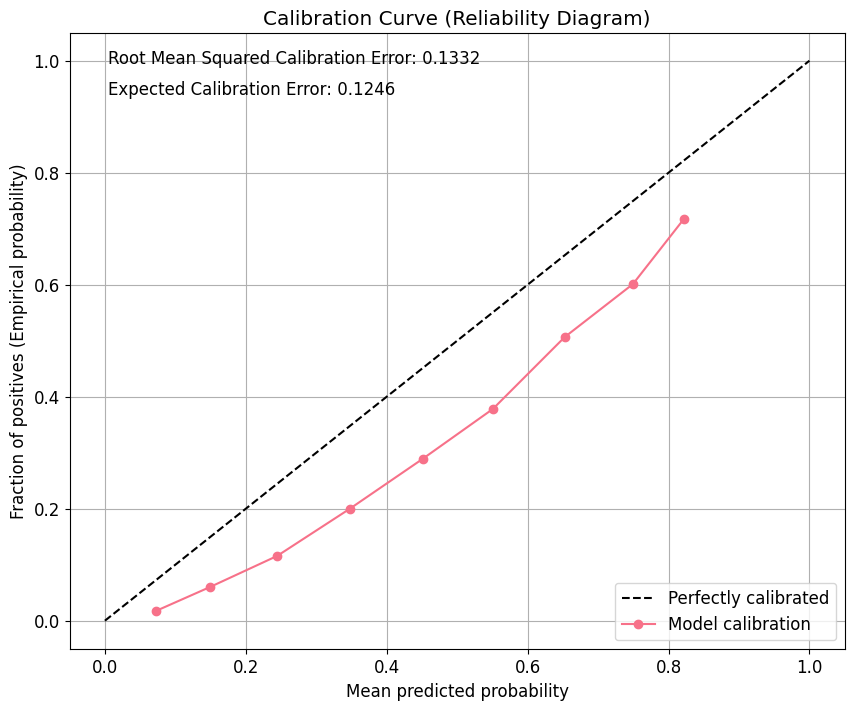

In [20]:
# Evaluate calibration
print("\n📏 Evaluating probability calibration...")
calibration_metrics = confidence_scorer.evaluate_calibration(
    y_test_flat, test_probabilities, n_bins=10)


💰 Optimizing decision threshold based on business costs...


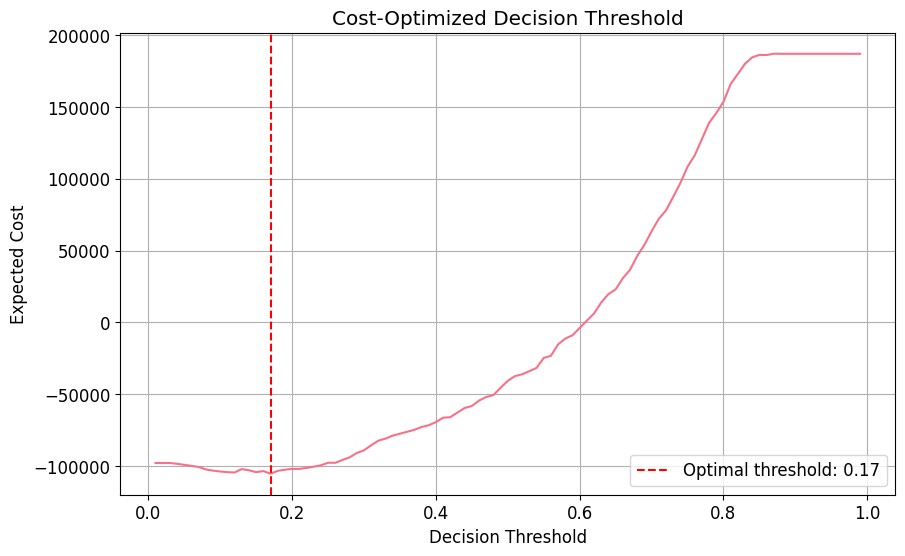

📊 Optimal decision threshold: 0.170
   • False Positive Cost: $50
   • False Negative Cost: $500
   • True Positive Benefit: $400


In [21]:
# Optimize threshold based on business costs
print("\n💰 Optimizing decision threshold based on business costs...")
telecom_costs = {
    'false_positive_cost': 50,      # Cost of retention campaign per customer
    'false_negative_cost': 500,     # Lost revenue from churned customer (lifetime value)
    'true_positive_benefit': 400     # Net benefit from successfully retained customer
}
optimal_threshold = confidence_scorer.optimize_threshold(
    y_test_flat, test_probabilities, cost_matrix=telecom_costs)

In [23]:
# Demonstrate confidence-based predictions
print("\n🎯 Generating predictions with confidence scores...")
# Get predictions for first 5 customers
sample_predictions = confidence_scorer.predict_with_confidence(test_probabilities[:5])

# Display results
print("\n📋 Sample Customer Predictions with Confidence:")
for i, pred in enumerate(sample_predictions):
    print(f"\nCustomer #{i+1}:")
    print(f"   • Churn Probability: {pred['probability']:.3f}")
    print(f"   • Prediction: {'Churn' if pred['prediction'] == 1 else 'No Churn'}")
    print(f"   • Risk Level: {pred['risk_level']}")
    print(f"   • Confidence: {pred['confidence']}")
    print(f"   • Recommended Action: {pred['recommended_action']}")
    print(f"   • Business Priority: {pred['business_priority']}")

# Summary
print("\n✅ Confidence scoring system implemented successfully")
print("   This system provides business-actionable predictions with associated confidence levels")
print("   and optimizes intervention thresholds based on specific business costs and benefits.")


🎯 Generating predictions with confidence scores...

📋 Sample Customer Predictions with Confidence:

Customer #1:
   • Churn Probability: 0.049
   • Prediction: No Churn
   • Risk Level: Very Low Risk
   • Confidence: Very High
   • Recommended Action: Standard Service
   • Business Priority: Low

Customer #2:
   • Churn Probability: 0.643
   • Prediction: Churn
   • Risk Level: High Risk
   • Confidence: High
   • Recommended Action: Targeted Offers
   • Business Priority: High

Customer #3:
   • Churn Probability: 0.048
   • Prediction: No Churn
   • Risk Level: Very Low Risk
   • Confidence: Very High
   • Recommended Action: Standard Service
   • Business Priority: Low

Customer #4:
   • Churn Probability: 0.500
   • Prediction: Churn
   • Risk Level: Uncertain
   • Confidence: Medium
   • Recommended Action: Enhanced Monitoring
   • Business Priority: Medium

Customer #5:
   • Churn Probability: 0.015
   • Prediction: No Churn
   • Risk Level: Very Low Risk
   • Confidence: Very H